In [ ]:
from sentence_transformers import SentenceTransformer
import numpy as np
import json

# Load enriched user data
with open("anudeep_d_enriched.json", "r", encoding="utf-8") as f:
    user_movies = json.load(f)

# Load sentence transformer
model = SentenceTransformer("all-MiniLM-L6-v2")

embeddings = []
weights = []

for movie in user_movies:
    rating = movie.get("rating")  # already numeric
    if movie["details"]:
        metadata = movie["details"]
        text = f"{movie['title']} {metadata.get('genres', '')} {metadata.get('synopsis', '')} Rating: {rating or ''}"
    elif rating:
        text = f"{movie['title']} Rating: {rating}"
    else:
        text = movie['title']

    emb = model.encode(text)
    weight = float(rating) if rating else 1.0

    embeddings.append(emb * weight)
    weights.append(weight)

# Final user vector (weighted average)
user_vector = np.sum(embeddings, axis=0) / np.sum(weights)

# Save the user vector
np.save("anudeep_d_user_vector.npy", user_vector)
print("User embedding saved to 'anudeep_d_user_vector.npy'")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

User embedding saved to 'anudeep_d_user_vector.npy'


In [ ]:
!pip install -q pymoo faiss-cpu sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.6/70.6 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 10.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 81.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 70.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 107.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.2 MB/s eta 0:00:00
  

In [ ]:
!pip install unidecode

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.8/235.8 kB 7.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import torch
import json
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation

# --- Load movie embeddings and user vector ---
embeddings = np.load("movie_embeddings.npy")
user_vector = np.load("anudeep_d_user_vector.npy")

# --- Load metadata and watched list ---
with open("letterboxd_movies.json", "r", encoding="utf-8") as f:
    movie_meta = json.load(f)

with open("anudeep_d_watched.json", "r", encoding="utf-8") as f:
    watched_data = json.load(f)
    watched_titles = set(m['title'] for m in watched_data if 'title' in m)

# --- Filter top 500 candidate movies ---
top_k = 500
candidate_indices = np.random.choice(len(embeddings), top_k, replace=False)
candidate_embeddings = embeddings[candidate_indices]
candidate_meta = [movie_meta[i] for i in candidate_indices]

# --- Problem setup ---
K = 5  # movies to recommend

class MovieRecProblem(ElementwiseProblem):
    def __init__(self, embeddings, user_vector, K):
        super().__init__(n_var=embeddings.shape[0],
                         n_obj=4,
                         n_eq_constr=1,
                         type_var=np.bool_)

        self.K = K
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.device = device
        self.embeddings = torch.tensor(embeddings, dtype=torch.float32, device=device)
        self.user_vector = torch.tensor(user_vector, dtype=torch.float32, device=device)
        self.centroid = torch.mean(self.embeddings, dim=0)

    def _evaluate(self, x, out, *args, **kwargs):
        selected_idx = np.where(x)[0]
        out["H"] = np.sum(x) - self.K

        if len(selected_idx) == 0:
            out["F"] = [0.0, 0.0, 0.0, 0.0]
            return

        sel = self.embeddings[selected_idx]

        norm_user = self.user_vector / torch.norm(self.user_vector)
        norm_sel = sel / torch.norm(sel, dim=1, keepdim=True)
        sim_score = torch.sum(norm_sel @ norm_user)

        if len(selected_idx) > 1:
            dists = torch.cdist(sel, sel, p=2)
            iu = torch.triu_indices(len(selected_idx), len(selected_idx), offset=1)
            pairwise = dists[iu[0], iu[1]]
            diversity = torch.var(pairwise)
            coverage = torch.mean(pairwise)
        else:
            diversity = torch.tensor(0.0, device=self.device)
            coverage = torch.tensor(0.0, device=self.device)

        novelty = torch.sum(torch.norm(sel - self.centroid, dim=1))

        out["F"] = [
            -sim_score.item(),
            -diversity.item(),
            -novelty.item(),
            -coverage.item()
        ]

# --- Run optimization ---
problem = MovieRecProblem(candidate_embeddings, user_vector, K)
ref_dirs = get_reference_directions("das-dennis", 4, n_partitions=6)  # ~80 refs

algorithm = NSGA3(
    pop_size=len(ref_dirs),
    ref_dirs=ref_dirs,
    sampling=BinaryRandomSampling(),
    crossover=TwoPointCrossover(),
    mutation=BitflipMutation(),
    eliminate_duplicates=True
)

res = minimize(problem,
               algorithm,
               termination=('n_gen', 200),
               seed=42,
               verbose=True)

# --- Post-processing: Show results without watched movies ---
def print_recs(res, meta, watched):
    count = 1
    for sol in res.X:
        selected = np.where(sol)[0]
        titles = [meta[i]['title'] for i in selected if meta[i]['title'] not in watched]
        if len(titles) < K:
            continue  # skip if watched movies dominate
        print(f"Solution {count}:")
        for title in titles:
            print(f"  - {title}")
        print()
        count += 1
        if count > 5:
            break

print("\nGenerated Recommendations (Filtered):\n")
print_recs(res, candidate_meta, watched_titles)


n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |       84 |      1 |  2.179999E+02 |  2.449642E+02 |             - |             -
     2 |      168 |      1 |  2.069999E+02 |  2.336547E+02 |             - |             -
     3 |      252 |      1 |  2.069999E+02 |  2.255951E+02 |             - |             -
     4 |      336 |      1 |  2.069999E+02 |  2.183332E+02 |             - |             -
     5 |      420 |      1 |  1.929999E+02 |  2.119404E+02 |             - |             -
     6 |      504 |      1 |  1.929999E+02 |  2.063689E+02 |             - |             -
     7 |      588 |      1 |  1.929999E+02 |  2.017737E+02 |             - |             -
     8 |      672 |      1 |  1.859999E+02 |  1.975118E+02 |             - |             -
     9 |      756 |      1 |  1.809999E+02 |  1.935594E+02 |             - |             -
    10 |      840 |      1 |  1.769999E+02 |  1.894285E+02 |             - |             -

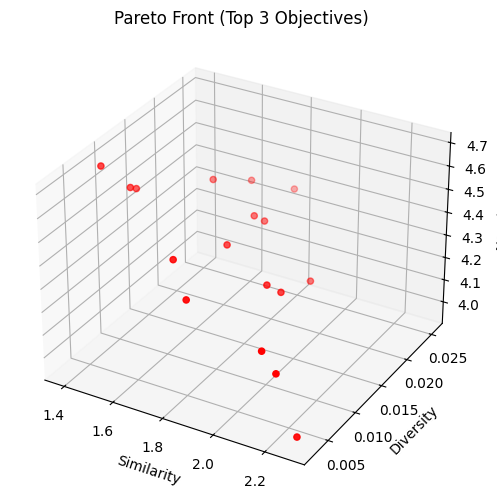

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

F = res.F
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(-F[:, 0], -F[:, 1], -F[:, 2], c='red', marker='o')
ax.set_xlabel('Similarity')
ax.set_ylabel('Diversity')
ax.set_zlabel('Novelty')
plt.title("Pareto Front (Top 3 Objectives)")
plt.show()



🎯 Final RL-Weighted Recommendations (After 500 Sessions):
  1. Rekhachithram
  2. Kalki 2898-AD
  3. Indian 2: Zero Tolerance
  4. Three of Us
  5. Dhoom 2


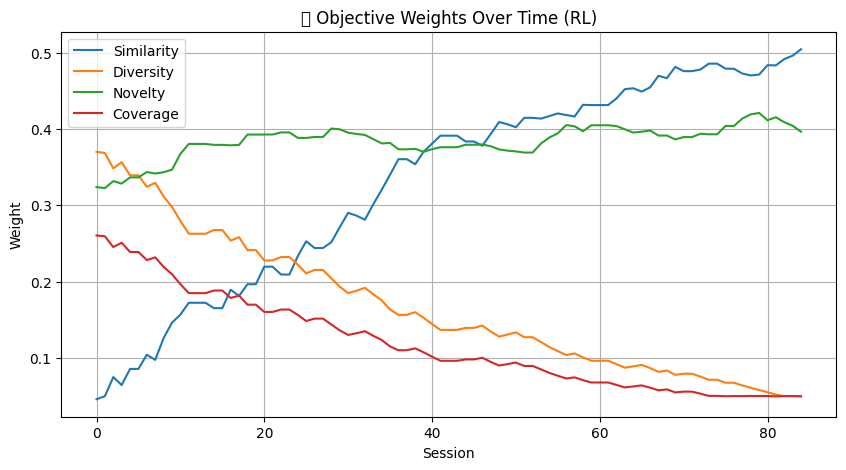

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# --- Constants ---
K = 5
sessions = 500
learning_rate = 0.05
punishment_rate = 0.02
epsilon = 0.15

# --- Compute full_F if not already computed ---
def compute_objectives_all(embeddings, user_vector):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    emb = torch.tensor(embeddings, dtype=torch.float32, device=device)
    user = torch.tensor(user_vector, dtype=torch.float32, device=device)
    centroid = torch.mean(emb, dim=0)

    norm_user = user / torch.norm(user)
    norm_emb = emb / torch.norm(emb, dim=1, keepdim=True)
    sim_score = (norm_emb @ norm_user).squeeze()


    diversity = torch.zeros(len(emb), device=device)
    coverage = torch.zeros(len(emb), device=device)
    novelty = torch.norm(emb - centroid, dim=1)

    F = torch.stack([
        sim_score,
        diversity,
        novelty,
        coverage
    ], dim=1).cpu().numpy()

    return F

full_F = compute_objectives_all(embeddings, user_vector)

# --- Normalize full_F ---
F_norm = (full_F - full_F.min(axis=0)) / (full_F.max(axis=0) - full_F.min(axis=0) + 1e-8)

# --- Setup ---
watched_titles = set(m['title'] for m in watched_data if 'title' in m)
interacted_titles = set()
weights = np.random.rand(4)
weights /= weights.sum()

weight_history = [weights.copy()]
reward_history = []

# --- RL Sessions ---
for step in range(sessions):
    if np.random.rand() < epsilon:
        idx = np.random.choice(len(F_norm))
    else:
        scores = F_norm @ weights
        idx = np.argmax(scores)

    title = movie_meta[idx].get("title", None)
    if not title or title in watched_titles or title in interacted_titles:
        continue

    # Simulate reward
    reward = np.random.choice([1, 0, -1], p=[0.5, 0.3, 0.2])
    reward_history.append(reward)
    interacted_titles.add(title)

    # Update weights
    if reward == 1:
        weights += learning_rate * (F_norm[idx] - weights)
    elif reward == -1:
        weights -= punishment_rate * (F_norm[idx] - weights)

    # Prevent collapse of any objective
    weights = np.clip(weights, [0.05]*4, None)
    weights /= weights.sum()
    weight_history.append(weights.copy())

# --- Final Recommendation from Updated Weights ---
final_scores = F_norm @ weights
sorted_idxs = np.argsort(-final_scores)

final_recs = []
for idx in sorted_idxs:
    title = movie_meta[idx].get("title", None)
    if title and title not in watched_titles and title not in interacted_titles:
        final_recs.append(title)
    if len(final_recs) >= K:
        break

# --- Output ---
print("\n🎯 Final RL-Weighted Recommendations (After", sessions, "Sessions):")
for i, title in enumerate(final_recs, 1):
    print(f"  {i}. {title}")

# --- Plotting ---
weight_history = np.array(weight_history)
labels = ["Similarity", "Diversity", "Novelty", "Coverage"]

plt.figure(figsize=(10, 5))
for i in range(4):
    plt.plot(weight_history[:, i], label=labels[i])
plt.title("📈 Objective Weights Over Time (RL)")
plt.xlabel("Session")
plt.ylabel("Weight")
plt.legend()
plt.grid(True)
plt.show()
